In [1]:
##########
# Imports
##########

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# PyTorch stuff
import torch
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data.sampler import SequentialSampler

# Albumenations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# DICOM Helpers
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [2]:
# Read in train.csv
train_df = pd.read_csv('train.csv')

# Use image_ids as key
image_ids = train_df['image_id'].unique()

# Use sklearn train_test_split to get train set
train_ids, _ = train_test_split(image_ids, test_size=0.9, random_state=32)

# Split train set into train/val sets
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=32)

print('Train size: ', len(train_ids))
print('Val size: ', len(val_ids))

Train size:  1350
Val size:  150


In [3]:
# Create dataframes according to image_ids for train/val sets
val_df = train_df[train_df['image_id'].isin(val_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [4]:
# Preview train_df (note: there is a row for each finding provided by each radiologist, so # rows will exceed # images)
# Also note that there are NaN values for 'No finding'. We'll have to change these values.
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
24,fc06d54844aee54acd87466f59acfc5b,No finding,14,R5,NaN,NaN,NaN,NaN
32,5d03f4c2d353a2ddfdc4ba932e5b1029,No finding,14,R6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67842,1ed4cf45940bbfbcdc31cf4289c1c1e4,Aortic enlargement,0,R10,1416.0,741.0,1719.0,983.0
67854,dab8bef96e96c74e44e44b513760086b,Infiltration,6,R10,396.0,1028.0,999.0,1812.0
67861,6c570356c5cdb674231769b436f31d1f,No finding,14,R16,NaN,NaN,NaN,NaN
67885,f4da0959856bcdd4b91e0c6949b109e3,Aortic enlargement,0,R9,1567.0,827.0,1830.0,1124.0


In [5]:
# Replace NaN values for both dataframes
train_df.fillna(0, inplace=True)
train_df.loc[train_df["class_id"] == 14, ['x_max', 'y_max']] = 1.0

val_df.fillna(0, inplace=True)
val_df.loc[val_df["class_id"] == 14, ['x_max', 'y_max']] = 1.0

train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,0.0,0.0,1.0,1.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,0.0,0.0,1.0,1.0
24,fc06d54844aee54acd87466f59acfc5b,No finding,14,R5,0.0,0.0,1.0,1.0
32,5d03f4c2d353a2ddfdc4ba932e5b1029,No finding,14,R6,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
67842,1ed4cf45940bbfbcdc31cf4289c1c1e4,Aortic enlargement,0,R10,1416.0,741.0,1719.0,983.0
67854,dab8bef96e96c74e44e44b513760086b,Infiltration,6,R10,396.0,1028.0,999.0,1812.0
67861,6c570356c5cdb674231769b436f31d1f,No finding,14,R16,0.0,0.0,1.0,1.0
67885,f4da0959856bcdd4b91e0c6949b109e3,Aortic enlargement,0,R9,1567.0,827.0,1830.0,1124.0


In [6]:
# Check if resulting dataframes are the correct size
print('# train images: ', len(train_df['image_id'].unique()))
print('# val images: ', len(val_df['image_id'].unique()))

# train images:  1350
# val images:  150


In [7]:
# From: https://www.kaggle.com/pestipeti/vinbigdata-fasterrcnn-pytorch-train

class ChestXrayTrainDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[(self.df['image_id'] == image_id)]
        records = records.reset_index(drop=True)

        dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")
        
        image = dicom.pixel_array
        
        if "PhotometricInterpretation" in dicom:
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                image = np.amax(image) - image
        
        intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
        slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0
        
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
            
        image += np.int16(intercept)        
        
        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image * 255.0
        image = image.transpose(1,2,0)
       
        if records.loc[0, "class_id"] == 0:
            records = records.loc[[0], :]
        
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.tensor(sample['bboxes'])

        if target["boxes"].shape[0] == 0:
            # Albumentation cuts the target (class 14, 1x1px in the corner)
            target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
            target["area"] = torch.tensor([1.0], dtype=torch.float32)
            target["labels"] = torch.tensor([0], dtype=torch.int64)
            
        return image, target, records
    
    def __len__(self):
        return self.image_ids.shape[0]
    
def collate_fn(batch):
    return tuple(zip(*batch))

# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),

        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# train_df = pd.read_csv('train.csv')
# train_df.fillna(0, inplace=True)
# train_df.loc[train_df["class_id"] == 14, ['x_max', 'y_max']] = 1.0

# NEED TO CALL TRANSFORM FUNCTION TO AVOID .to(device) ERROR FOR NUMPY TYPE
train_dataset = ChestXrayTrainDataset(train_df, 'train', get_train_transform())
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn)

In [9]:
images, targets, records = next(iter(train_dataloader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

/home/chris/anaconda3/envs/pytorch/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "
/home/chris/anaconda3/envs/pytorch/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


In [10]:
container = (targets[2]['boxes'].cpu().numpy().astype(np.int32), targets[2]['labels'])
sample = images[2].permute(1,2,0).cpu().numpy()
record = records[2]
print(record)

                           image_id  class_name  class_id rad_id  x_min  \
0  063319de25ce7edb9b1c6b8881290140  No finding        14    R10    0.0   
1  063319de25ce7edb9b1c6b8881290140  No finding        14     R8    0.0   
2  063319de25ce7edb9b1c6b8881290140  No finding        14     R9    0.0   

   y_min  x_max  y_max  
0    0.0    1.0    1.0  
1    0.0    1.0    1.0  
2    0.0    1.0    1.0  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


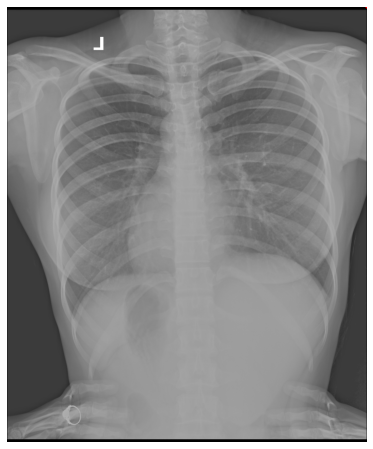

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

boxes, labels = container

for box, label in zip(boxes, labels):
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    cv2.putText(sample, str(label.cpu().numpy()), (box[2]+5, box[3]-12), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0))
    
ax.set_axis_off()
ax.imshow(sample)

# Train a model

In [12]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

if os.path.exists("saved_model.pth"):  # checking if there is a file with this name
    model = torch.load("saved_model.pth")
    model.eval()

num_classes = 15

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [13]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs = 2

loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, _ in train_dataloader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 100 == 0:
            print(f"Iteration #{itr} loss: {loss_hist.value}")

        itr += 1
        
#         # !!!REMOVE THIS!!!
#         break
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    # print("Saving epoch's state...")
    torch.save(model, f"saved_model.pth")

/home/chris/anaconda3/envs/pytorch/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "
/home/chris/anaconda3/envs/pytorch/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


Iteration #100 loss: 0.8076762434922581
Iteration #200 loss: 0.6323016514741205
Iteration #300 loss: 0.5202854290060525
Iteration #400 loss: 0.4451968978561658
Epoch #0 loss: 0.41807389067698686
Iteration #500 loss: 0.6206977577081914
Iteration #600 loss: 0.5027914014364179
Iteration #700 loss: 0.4378437258604423
Iteration #800 loss: 0.3889556203428327
Iteration #900 loss: 0.34022907614093084
Epoch #1 loss: 0.34022907614093084


## Evaluate Model on Validation Set

In [14]:
val_dataset = ChestXrayTrainDataset(val_df, 'train', get_train_transform())
val_dataloader = DataLoader(val_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn)
images, targets, records = next(iter(val_dataloader))

/home/chris/anaconda3/envs/pytorch/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "
/home/chris/anaconda3/envs/pytorch/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


In [15]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(                            image_id          class_name  class_id rad_id  \
0   7eda1e28e4cee7d8016276c87b76259f  Pleural thickening        11     R8   
1   7eda1e28e4cee7d8016276c87b76259f  Pleural thickening        11    R10   
2   7eda1e28e4cee7d8016276c87b76259f        Other lesion         9    R10   
3   7eda1e28e4cee7d8016276c87b76259f  Pleural thickening        11     R9   
4   7eda1e28e4cee7d8016276c87b76259f    Pleural effusion        10     R9   
5   7eda1e28e4cee7d8016276c87b76259f    Pleural effusion        10     R8   
6   7eda1e28e4cee7d8016276c87b76259f  Pleural thickening        11    R10   
7   7eda1e28e4cee7d8016276c87b76259f  Pulmonary fibrosis        13     R8   
8   7eda1e28e4cee7d8016276c87b76259f  Pleural thickening        11     R9   
9   7eda1e28e4cee7d8016276c87b76259f  Pulmonary fibrosis        13     R8   
10  7eda1e28e4cee7d8016276c87b76259f  Pleural thickening        11     R9   
11  7eda1e28e4cee7d8016276c87b76259f  Pleural thickening        11    R10  

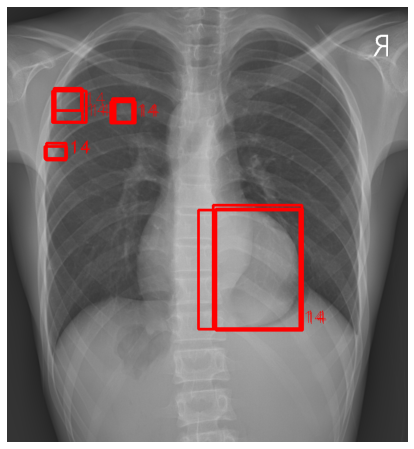

In [16]:
container = (targets[2]['boxes'].cpu().numpy().astype(np.int32), targets[2]['labels'])
sample = images[2].permute(1,2,0).cpu().numpy()
print(records)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

boxes, labels = container

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    cv2.putText(sample, str(label.cpu().numpy()), (box[2]+5, box[3]-12), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0))
    
ax.set_axis_off()
ax.imshow(sample)

In [17]:
outputs

[{'boxes': tensor([[0.0000e+00, 7.9990e+02, 1.5926e-02, 8.0000e+02],
          [1.5831e-01, 7.9971e+02, 3.7126e-01, 7.9997e+02],
          [3.2603e-01, 7.9974e+02, 6.0081e-01, 8.0000e+02],
          [1.8578e-01, 7.9926e+02, 4.0668e-01, 7.9947e+02],
          [6.7796e+02, 2.0778e+02, 6.7800e+02, 2.0802e+02],
          [6.7791e+02, 7.9721e+02, 6.7800e+02, 7.9752e+02],
          [2.4515e-01, 7.9892e+02, 4.7521e-01, 7.9919e+02],
          [6.7796e+02, 2.0778e+02, 6.7800e+02, 2.0802e+02],
          [6.7791e+02, 7.9721e+02, 6.7800e+02, 7.9752e+02],
          [6.7791e+02, 7.9722e+02, 6.7800e+02, 7.9752e+02],
          [6.7796e+02, 2.0779e+02, 6.7800e+02, 2.0802e+02],
          [6.7791e+02, 7.9721e+02, 6.7800e+02, 7.9752e+02],
          [6.7796e+02, 2.0778e+02, 6.7800e+02, 2.0802e+02],
          [6.7796e+02, 2.0778e+02, 6.7800e+02, 2.0802e+02],
          [6.7791e+02, 7.9721e+02, 6.7800e+02, 7.9752e+02]],
         grad_fn=<CopyBackwards>),
  'labels': tensor([14, 14, 14, 14, 14, 14, 14, 13, 13,

## Visualize Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


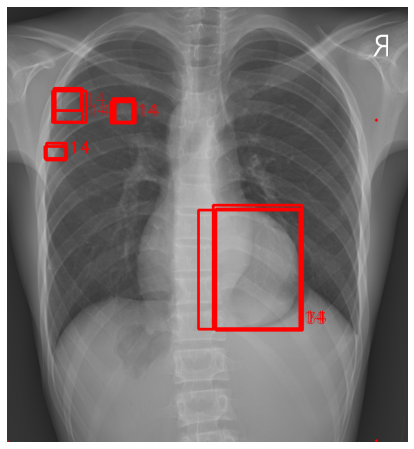

In [18]:
out_boxes = outputs[0].get('boxes')
out_labels = outputs[0].get('labels')
out_scores = outputs[0].get('scores')

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for out_box, out_label in zip(out_boxes, out_labels):
    cv2.rectangle(sample,
                  (out_box[0], out_box[1]),
                  (out_box[2], out_box[3]),
                  (220, 0, 0), 3)
    cv2.putText(sample, str(out_label.cpu().numpy()), (box[2]+5, box[3]-12), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0))
    
ax.set_axis_off()
ax.imshow(sample)